## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, recall_score, precision_score, roc_auc_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import pprint
pp = pprint.PrettyPrinter(indent=4)

## Importing data

In [2]:
loans = pd.read_csv("loan_approval_dataset.csv")
loans.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [4]:
loans.columns = loans.columns.str.strip() #some text had empty space

## Appendix graph, before CIBIL score is dropped

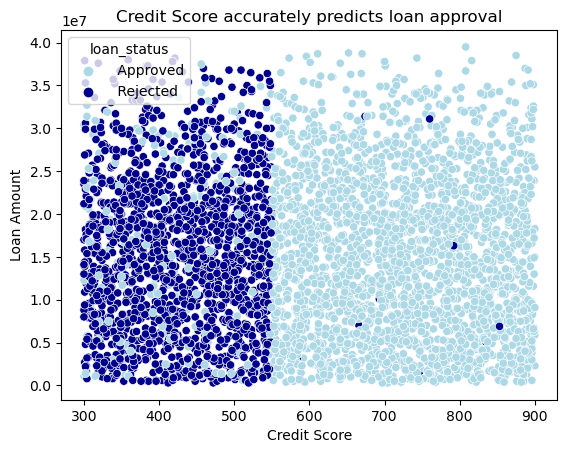

In [5]:
blue_palette = ["lightblue", "darkblue"]
sns.scatterplot(x=loans['cibil_score'], y= loans['loan_amount'], hue=loans['loan_status'],palette = blue_palette)
plt.title("Credit Score accurately predicts loan approval")
plt.xlabel("Credit Score")
plt.ylabel("Loan Amount")
plt.show()

## Cleaning

In [6]:
loans.drop("loan_id", axis=1, inplace=True)
loans.drop("cibil_score", axis=1, inplace=True) # Only consider 1st time applicants

loans['education'] = loans['education'].str.strip()
loans['self_employed'] = loans['self_employed'].str.strip()
loans['loan_status'] = loans['loan_status'].str.strip()

loans["education"] = loans["education"].replace({"Graduate" : 1, "Not Graduate" : 0})
loans["self_employed"] = loans["self_employed"].replace({"Yes" : 1, "No" : 0})
loans["loan_status"] = loans["loan_status"].replace({"Approved" : 1, "Rejected" : 0})

loans.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,12400000,8200000,29400000,5000000,0


## Data overview

In [7]:
loans.nunique()

no_of_dependents              6
education                     2
self_employed                 2
income_annum                 98
loan_amount                 378
loan_term                    10
residential_assets_value    278
commercial_assets_value     188
luxury_assets_value         379
bank_asset_value            146
loan_status                   2
dtype: int64

loan_status
1    2656
0    1613
Name: count, dtype: int64


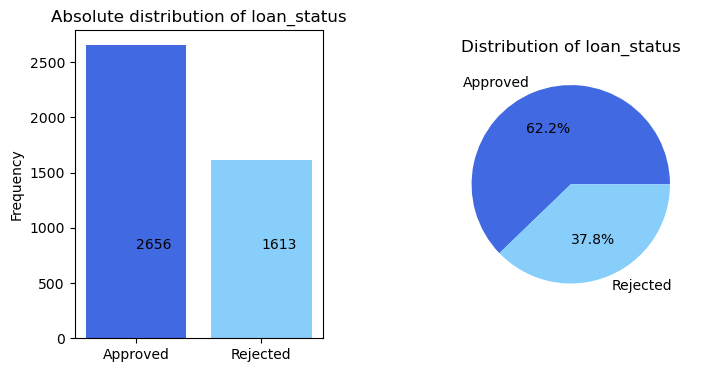

In [8]:
class_counts=loans["loan_status"].value_counts()
print(class_counts)

plt.figure(figsize=(8, 4))
           
plt.subplot(1,2,1)
plt.bar(["Approved", "Rejected"], class_counts, color = ["royalblue", "lightskyblue"])
plt.title("Absolute distribution of loan_status")
plt.ylabel("Frequency")
plt.text(["Approved"], class_counts[0]/2, class_counts[1])
plt.text(["Rejected"], class_counts[0]/2, class_counts[0])

plt.subplot(1,2,2)
plt.pie(class_counts, labels=["Approved", "Rejected"], autopct="%1.1f%%", colors= ["royalblue", "lightskyblue"])
plt.title("Distribution of loan_status")

plt.subplots_adjust(wspace=0.5)
plt.show()

## Descriptive variable analysis

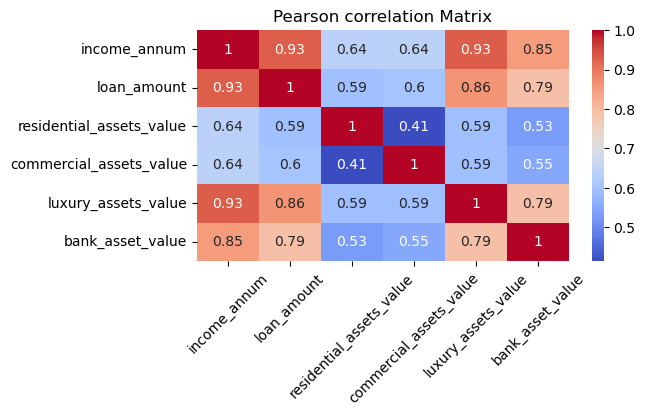

In [9]:
cont = loans[['income_annum', 'loan_amount', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']]
corr_matrix = cont.corr()

plt.figure(figsize=(6, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Pearson correlation Matrix')
plt.xticks(rotation=45)
plt.show()

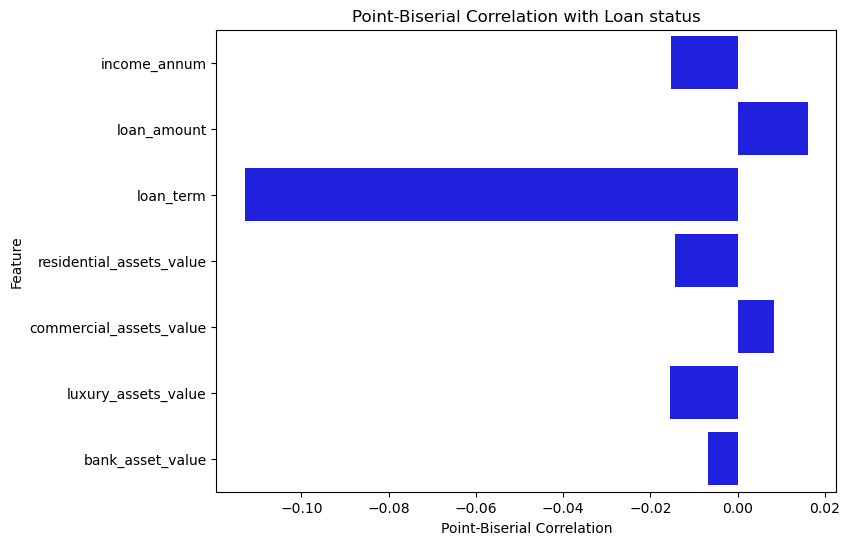

In [10]:
continuous_features = ['income_annum', 'loan_amount', 'loan_term', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
target_variable ='loan_status'

# Calculate Point-Biserial Correlation for each feature
correlations = {}
for feature in continuous_features:
    correlation, p_value = stats.pointbiserialr(loans[feature], loans[target_variable])
    correlations[feature] = correlation

correlation_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Point-Biserial Correlation'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Point-Biserial Correlation', y='Feature', data=correlation_df, color='blue')
plt.title('Point-Biserial Correlation with Loan status')
plt.xlabel('Point-Biserial Correlation')
plt.ylabel('Feature')
plt.show()

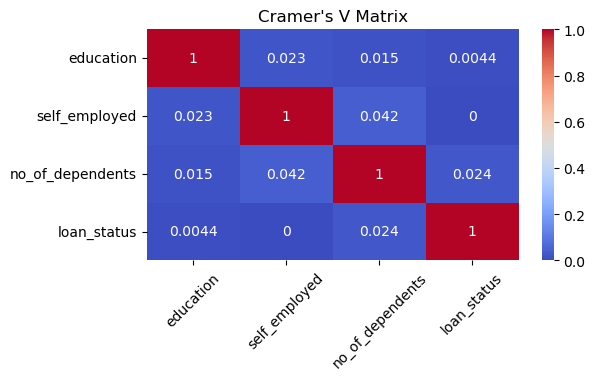

In [11]:
df = loans[['education', 'self_employed', 'no_of_dependents', 'loan_status']]

# create the contingency table matrix
def contingency_table_matrix(df):
    columns = df.columns
    matrix = np.zeros((len(columns), len(columns)))
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            contingency_table = pd.crosstab(df[col1], df[col2])
            chi2, _, _, _ = stats.chi2_contingency(contingency_table)
            min_categories = min(contingency_table.shape[0], contingency_table.shape[1])
            n = contingency_table.sum().sum()
            V = np.sqrt(chi2 / (n * (min_categories - 1)))
            matrix[i, j] = V
    return pd.DataFrame(matrix, columns=columns, index=columns)

# generate the Cramer's V coefficient matrix
cramers_v_matrix = contingency_table_matrix(df)

plt.figure(figsize=(6, 3))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm')

plt.title("Cramer's V Matrix")
plt.xticks(rotation=45)
plt.show()

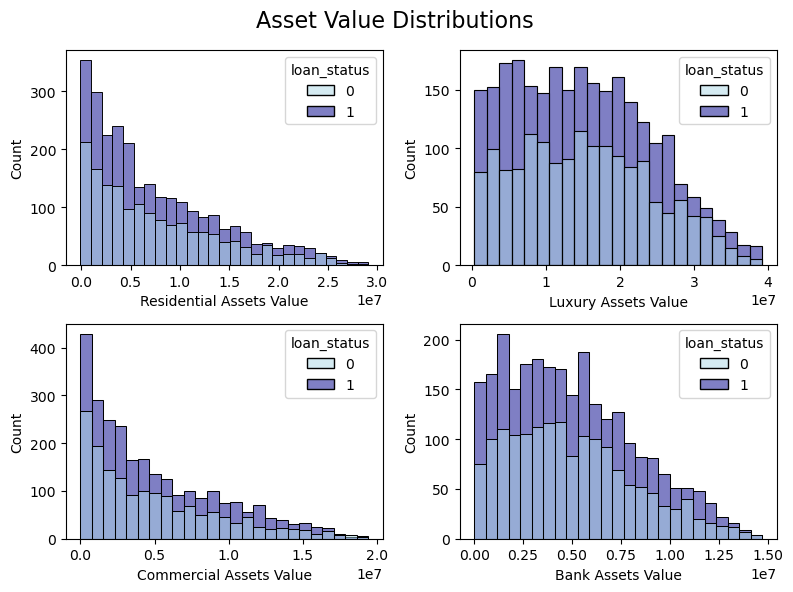

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

blue_palette = ["lightblue", "darkblue"]

sns.histplot(loans, x='residential_assets_value', hue='loan_status', palette=blue_palette, ax=axes[0, 0])
axes[0, 0].set_xlabel("Residential Assets Value")
axes[0, 0].set_ylabel("Count")


sns.histplot(loans, x='commercial_assets_value', hue='loan_status', palette=blue_palette, ax=axes[1, 0])
axes[1, 0].set_xlabel("Commercial Assets Value")
axes[1, 0].set_ylabel("Count")


sns.histplot(loans, x='luxury_assets_value', hue='loan_status', palette=blue_palette, ax=axes[0, 1])
axes[0, 1].set_xlabel("Luxury Assets Value")
axes[0, 1].set_ylabel("Count")


sns.histplot(loans, x='bank_asset_value', hue='loan_status', palette=blue_palette, ax=axes[1, 1])
axes[1, 1].set_xlabel("Bank Assets Value")
axes[1, 1].set_ylabel("Count")


plt.suptitle("Asset Value Distributions", fontsize=16)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3194/1054640245.py:5: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.histplot(loans, x='loan_term', hue='loan_status', palette=blue_palette, binwidth=1, discrete=True)


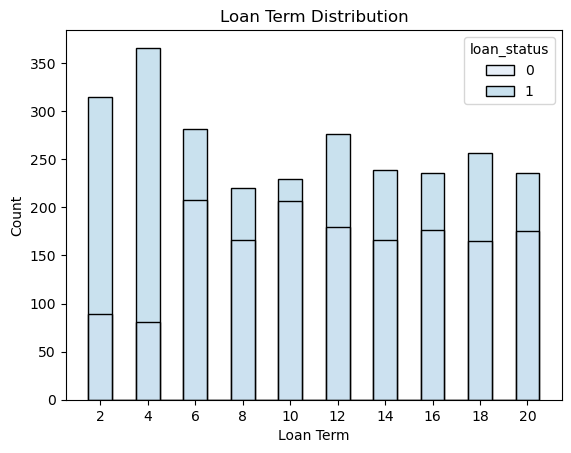

In [13]:
# Define a blue color palette with 4 different shades
blue_palette = sns.color_palette("Blues", 4)

# Create the histogram plot treating "loan_term" as a discrete variable
sns.histplot(loans, x='loan_term', hue='loan_status', palette=blue_palette, binwidth=1, discrete=True)

# Set plot title and labels
plt.title("Loan Term Distribution")
plt.xlabel("Loan Term")
plt.ylabel("Count")

# Customize the x-axis ticks
plt.xticks(range(2, 21, 2))

plt.show()

## Partitioning

In [14]:
X = loans.drop("loan_status", axis=1)
y = loans["loan_status"]

In [15]:
# Split training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=0.3)

# Comparing accuracies
accs_base = {"lr":0, "dtc":0, "rfc":0, "xgb":0}

# Comparing rocauc
rocauc_base = {"lr":0, "dtc":0, "rfc":0, "xgb":0}

# Balancing with smote
smote = SMOTE(random_state = 1234)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

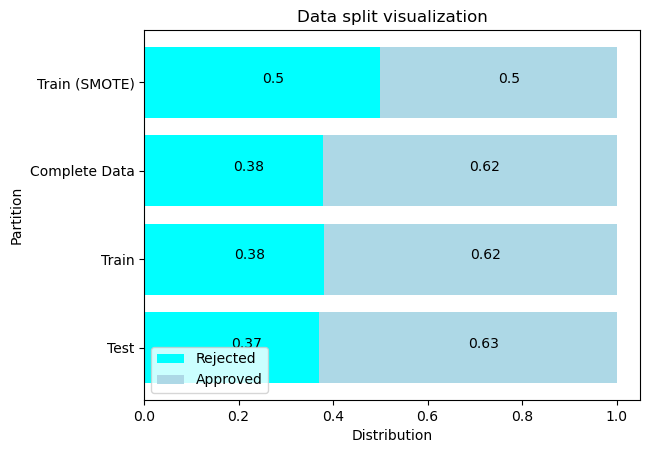

In [16]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
loans_dist = loans["loan_status"].value_counts() / len(loans)
smote_dist = pd.Series(y_train_smote).value_counts() / len(pd.Series(y_train_smote))

fig, ax = plt.subplots()

ax.barh(['Test','Train','Complete Data', 'Train (SMOTE)'], [ test_dist[0], train_dist[0], loans_dist[0], smote_dist[0]], color='cyan', label='Rejected')
ax.barh(['Test','Train','Complete Data', 'Train (SMOTE)'], [ test_dist[1], train_dist[1], loans_dist[1], smote_dist[1]], left=[ test_dist[0], train_dist[0], loans_dist[0], smote_dist[0]], color='lightblue', label='Approved')
ax.set_title('Data split visualization')
ax.legend(loc='lower left')
plt.xlabel('Distribution')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip([ 'Test', 'Train','Complete Data', 'Train (SMOTE)'], [ test_dist[0], train_dist[0], loans_dist[0], smote_dist[0]], [test_dist[1], train_dist[1], loans_dist[1], smote_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## Creating base models

In [17]:
# Base models
lr = LogisticRegression(random_state=1234)
dtc = DecisionTreeClassifier(random_state=1234)
rfc = RandomForestClassifier(random_state=1234)
xgb = XGBClassifier(random_state=1234)

## Unbalanced models

In [18]:
accs_base["lr"] = cross_val_score(lr, X_train, y_train).mean()
accs_base["dtc"] = cross_val_score(dtc, X_train, y_train).mean()
accs_base["rfc"] = cross_val_score(rfc, X_train, y_train).mean()
accs_base["xgb"] = cross_val_score(xgb, X_train, y_train).mean()

In [19]:
rocauc_base["lr"] = cross_val_score(lr, X_train, y_train, scoring = "roc_auc").mean()
rocauc_base["dtc"] = cross_val_score(dtc, X_train, y_train, scoring = "roc_auc").mean()
rocauc_base["rfc"] = cross_val_score(rfc, X_train, y_train, scoring = "roc_auc").mean()
rocauc_base["xgb"] = cross_val_score(xgb, X_train, y_train, scoring = "roc_auc").mean()

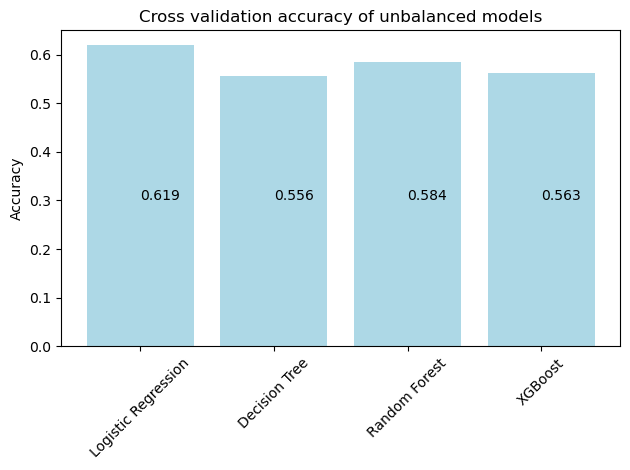

In [20]:
# Data from the accs_base dictionary
models = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]
accuracies = list(accs_base.values())

# Create a bar graph with a blue color palette
plt.bar(models, accuracies, color="lightblue")

# Adding labels and title
plt.ylabel('Accuracy')
plt.title('Cross validation accuracy of unbalanced models')
plt.xticks(rotation=45)

# Adding text
plt.text(["Logistic Regression"], 0.3, accs_base["lr"].round(3))
plt.text(["Decision Tree"], 0.3, accs_base["dtc"].round(3))
plt.text(["Random Forest"], 0.3, accs_base["rfc"].round(3))
plt.text(["XGBoost"], 0.3, accs_base["xgb"].round(3))

# Display the bar graph
plt.tight_layout()
plt.show()


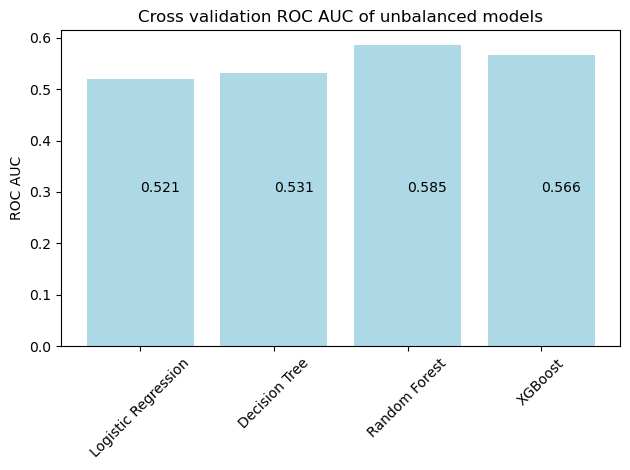

In [21]:
# Data from the accs_base dictionary
models = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]
rocaucs = list(rocauc_base.values())

# Create a bar graph with a blue color palette
plt.bar(models, rocaucs, color = "lightblue")

# Adding labels and title
plt.ylabel('ROC AUC')
plt.title('Cross validation ROC AUC of unbalanced models')
plt.xticks(rotation=45)

# Adding text
plt.text(["Logistic Regression"], 0.3, rocauc_base["lr"].round(3))
plt.text(["Decision Tree"], 0.3, rocauc_base["dtc"].round(3))
plt.text(["Random Forest"], 0.3, rocauc_base["rfc"].round(3))
plt.text(["XGBoost"], 0.3, rocauc_base["xgb"].round(3))

# Display the bar graph
plt.tight_layout()
plt.show()


## Smote balanced models

In [22]:
accs_bal = {"lr":0, "dtc":0, "rfc":0, "xgb":0}
rocauc_bal = {"lr":0, "dtc":0, "rfc":0, "xgb":0}

In [23]:
accs_bal["lr"] = cross_val_score(lr, X_train_smote, y_train_smote).mean()
accs_bal["dtc"] = cross_val_score(dtc, X_train_smote, y_train_smote).mean()
accs_bal["rfc"] = cross_val_score(rfc, X_train_smote, y_train_smote).mean()
accs_bal["xgb"] = cross_val_score(xgb, X_train_smote, y_train_smote).mean()

In [24]:
rocauc_bal["lr"] = cross_val_score(lr, X_train_smote, y_train_smote, scoring = "roc_auc").mean()
rocauc_bal["dtc"] = cross_val_score(dtc, X_train_smote, y_train_smote, scoring = "roc_auc").mean()
rocauc_bal["rfc"] = cross_val_score(rfc, X_train_smote, y_train_smote, scoring = "roc_auc").mean()
rocauc_bal["xgb"] = cross_val_score(xgb, X_train_smote, y_train_smote, scoring = "roc_auc").mean()

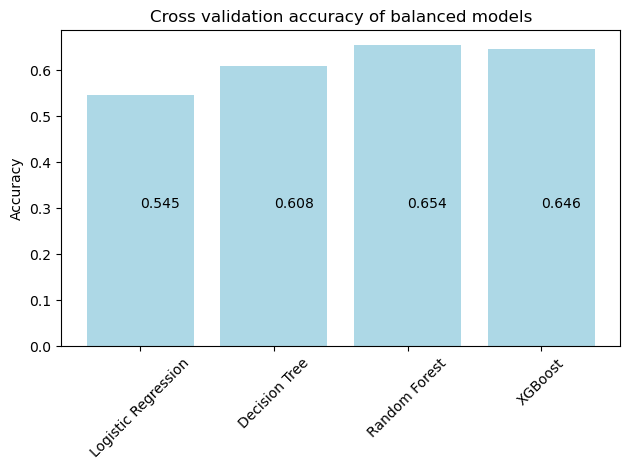

In [25]:
# Data from the accs_base dictionary
models = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]
accuracies = list(accs_bal.values())

# Create a bar graph with a blue color palette
plt.bar(models, accuracies, color = "lightblue")

# Adding labels and title
plt.ylabel('Accuracy')
plt.title('Cross validation accuracy of balanced models')
plt.xticks(rotation=45)

# Adding text
plt.text(["Logistic Regression"], 0.3, accs_bal["lr"].round(3))
plt.text(["Decision Tree"], 0.3, accs_bal["dtc"].round(3))
plt.text(["Random Forest"], 0.3, accs_bal["rfc"].round(3))
plt.text(["XGBoost"], 0.3, accs_bal["xgb"].round(3))

# Display the bar graph
plt.tight_layout()
plt.show()

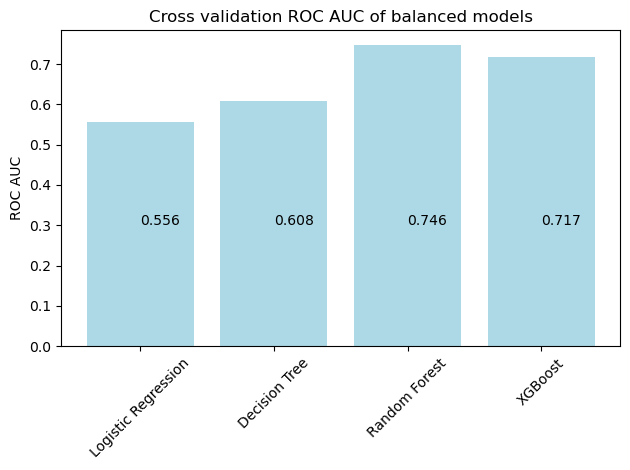

In [26]:
# Data from the accs_base dictionary
models = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]
rocaucs = list(rocauc_bal.values())

# Create a bar graph with a blue color palette
plt.bar(models, rocaucs, color='lightblue')

# Adding labels and title
plt.ylabel('ROC AUC')
plt.title('Cross validation ROC AUC of balanced models')
plt.xticks(rotation=45)

# Adding text
plt.text(["Logistic Regression"], 0.3, rocauc_bal["lr"].round(3))
plt.text(["Decision Tree"], 0.3, rocauc_bal["dtc"].round(3))
plt.text(["Random Forest"], 0.3, rocauc_bal["rfc"].round(3))
plt.text(["XGBoost"], 0.3, rocauc_bal["xgb"].round(3))

# Display the bar graph
plt.tight_layout()
plt.show()

## Random Over Sampling balanced models (not in presentation)

In [27]:
# Balancing with ROS
ros = RandomOverSampler(sampling_strategy='minority', random_state = 1234)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [28]:
accs_ros = {"lr":0, "dtc":0, "rfc":0, "xgb":0}
rocauc_ros = {"lr":0, "dtc":0, "rfc":0, "xgb":0}

In [29]:
accs_ros["lr"] = cross_val_score(lr, X_train_ros, y_train_ros).mean()
accs_ros["dtc"] = cross_val_score(dtc, X_train_ros, y_train_ros).mean()
accs_ros["rfc"] = cross_val_score(rfc, X_train_ros, y_train_ros).mean()
accs_ros["xgb"] = cross_val_score(xgb, X_train_ros, y_train_ros).mean()

In [30]:
rocauc_ros["lr"] = cross_val_score(lr, X_train_ros, y_train_ros, scoring = "roc_auc").mean()
rocauc_ros["dtc"] = cross_val_score(dtc, X_train_ros, y_train_ros, scoring = "roc_auc").mean()
rocauc_ros["rfc"] = cross_val_score(rfc, X_train_ros, y_train_ros, scoring = "roc_auc").mean()
rocauc_ros["xgb"] = cross_val_score(xgb, X_train_ros, y_train_ros, scoring = "roc_auc").mean()

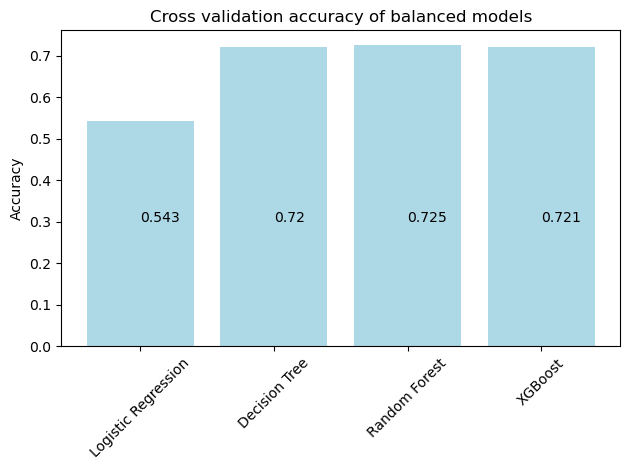

In [31]:
# Data from the accs_base dictionary
models = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]
accuracies = list(accs_ros.values())

# Create a bar graph with a blue color palette
plt.bar(models, accuracies, color = "lightblue")

# Adding labels and title
plt.ylabel('Accuracy')
plt.title('Cross validation accuracy of balanced models')
plt.xticks(rotation=45)

# Adding text
plt.text(["Logistic Regression"], 0.3, accs_ros["lr"].round(3))
plt.text(["Decision Tree"], 0.3, accs_ros["dtc"].round(3))
plt.text(["Random Forest"], 0.3, accs_ros["rfc"].round(3))
plt.text(["XGBoost"], 0.3, accs_ros["xgb"].round(3))

# Display the bar graph
plt.tight_layout()
plt.show()

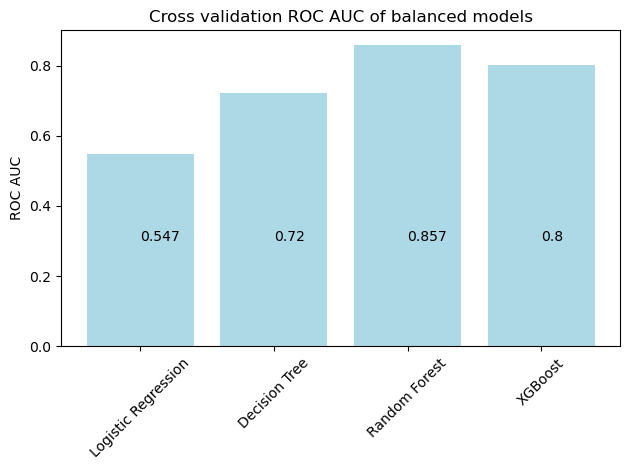

In [32]:
# Data from the accs_base dictionary
models = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]
rocaucs = list(rocauc_ros.values())

# Create a bar graph with a blue color palette
plt.bar(models, rocaucs, color='lightblue')

# Adding labels and title
plt.ylabel('ROC AUC')
plt.title('Cross validation ROC AUC of balanced models')
plt.xticks(rotation=45)

# Adding text
plt.text(["Logistic Regression"], 0.3, rocauc_ros["lr"].round(3))
plt.text(["Decision Tree"], 0.3, rocauc_ros["dtc"].round(3))
plt.text(["Random Forest"], 0.3, rocauc_ros["rfc"].round(3))
plt.text(["XGBoost"], 0.3, rocauc_ros["xgb"].round(3))

# Display the bar graph
plt.tight_layout()
plt.show()

## Feature selection (Balanced RFC)

In [33]:
# feature selection
brfc_sfs = SFS(
    rfc,
    k_features=(1, X_train_smote.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1,
)
brfc_sfs.fit(X_train_smote, y_train_smote)

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=1234),
                          k_features=(1, 10), n_jobs=-1, scoring='accuracy')

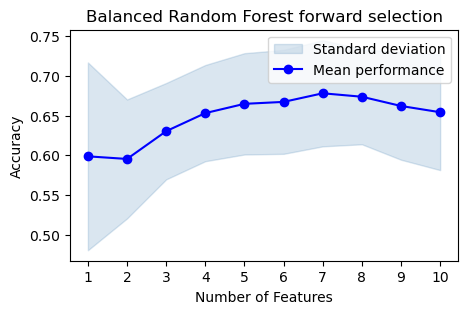

In [34]:
plot_sfs(brfc_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("Balanced Random Forest forward selection")
plt.legend(["Standard deviation", "Mean performance"])

In [35]:
brfc_sfs.k_feature_names_

('income_annum',
 'loan_amount',
 'loan_term',
 'residential_assets_value',
 'commercial_assets_value',
 'luxury_assets_value',
 'bank_asset_value')

In [36]:
brfc_sfs.k_score_

0.6779775445269356

In [37]:
X_train_brfc = brfc_sfs.transform(X_train_smote)
X_test_brfc = brfc_sfs.transform(X_test)
y_train_brfc = y_train_smote

## Hyperparameter tuning

In [38]:
# Define the hyperparameter grid for grid search
param_grid = {
    'n_estimators': [105],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    "criterion" : ["gini"],
    "max_features" : ["sqrt"]
}
#OPTIMAL PARAMETERS ONLY, SO THAT THE NOTEBOOK RUNS FASTER


# Create GridSearchCV object
brfc_cv = GridSearchCV(
    estimator=rfc, 
    param_grid=param_grid, 
    cv=5, 
    scoring="accuracy",
    refit=True, 
    n_jobs=-1, 
    verbose=1,
)

# Fit the model to the training data
brfc_cv.fit(X_train_brfc, y_train_brfc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [105]},
             scoring='accuracy', verbose=1)

In [39]:
# Retrieve the best parameters and best score
brfc_cv_best_params = brfc_cv.best_params_
brfc_cv_best_score = brfc_cv.best_score_

# Print the best parameters and best score
print("Best parameters:")
pp.pprint(brfc_cv_best_params)
print()
print("Best performance:")
print(brfc_cv_best_score)

Best parameters:
{   'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 105}

Best performance:
0.6820348900998427


## Final evaluation

In [40]:
y_pred_brfc_final = brfc_cv.predict(X_test_brfc)
accuracy = accuracy_score(y_test, y_pred_brfc_final)
recall = recall_score(y_test, y_pred_brfc_final)
precision = precision_score(y_test, y_pred_brfc_final)
rocauc_score = roc_auc_score(y_test, y_pred_brfc_final)
F1 = 2 * (precision * recall) / (precision + recall)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"AUC: {rocauc_score}")
print(f"F1 score: {F1}")

Accuracy: 0.5620608899297423
Recall: 0.6431226765799256
Precision: 0.6553030303030303
AUC: 0.533586654745659
F1 score: 0.649155722326454


In [41]:
balanced_rfc = RandomForestClassifier(random_state = 1234,
                                      criterion = 'gini',
                                      max_depth = None,
                                      max_features = 'sqrt',
                                      min_samples_leaf = 1,
                                      min_samples_split= 2,
                                      n_estimators = 105)

balanced_rfc.fit(X_train_brfc, y_train_brfc)

RandomForestClassifier(n_estimators=105, random_state=1234)

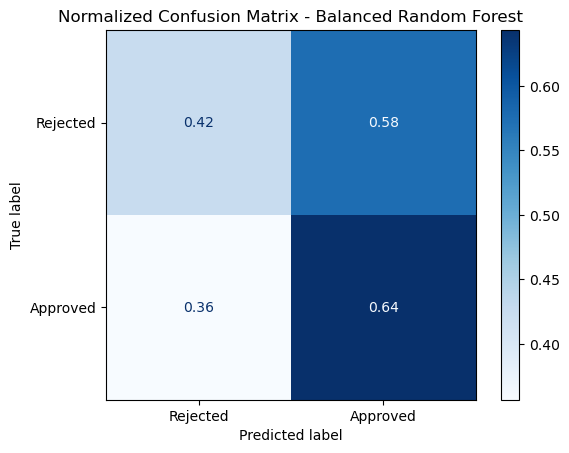

In [42]:
cmd_brfc_final = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_brfc_final, cmap="Blues", display_labels=["Rejected", "Approved"], normalize="true")

# Set a title for the confusion matrix display
cmd_brfc_final.ax_.set_title('Normalized Confusion Matrix - Balanced Random Forest')

# Display the confusion matrix
plt.show()

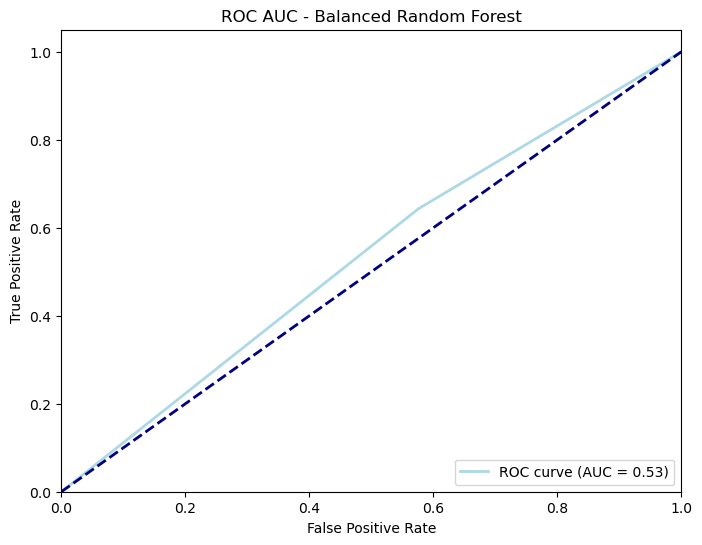

In [43]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_brfc_final)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='lightblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC - Balanced Random Forest')
plt.legend(loc='lower right')
plt.show()

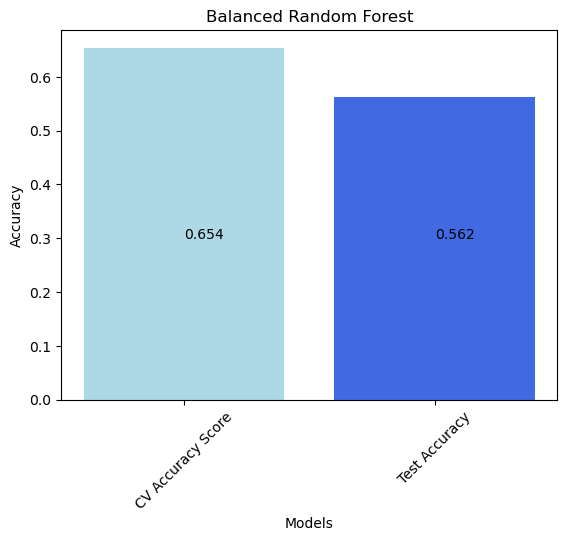

In [44]:
values = [accs_bal["rfc"], accuracy_score(y_test, y_pred_brfc_final)]

# Create a list of colors
colors = ['lightblue', 'royalblue']

# Create labels for each bar
labels = ['CV Accuracy Score', 'Test Accuracy',]

# Create a bar graph with customized colors
plt.bar(labels, values, color=colors)

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Balanced Random Forest')

# Adding text
plt.text(['CV Accuracy Score'], 0.3, accs_bal["rfc"].round(3))
plt.text(['Test Accuracy'], 0.3, accuracy_score(y_test, y_pred_brfc_final).round(3))

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Display the bar graph
plt.show()

#There is overfitting

In [45]:
start_time = time.time()
importances = balanced_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in balanced_rfc.estimators_], axis=0)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.022 seconds


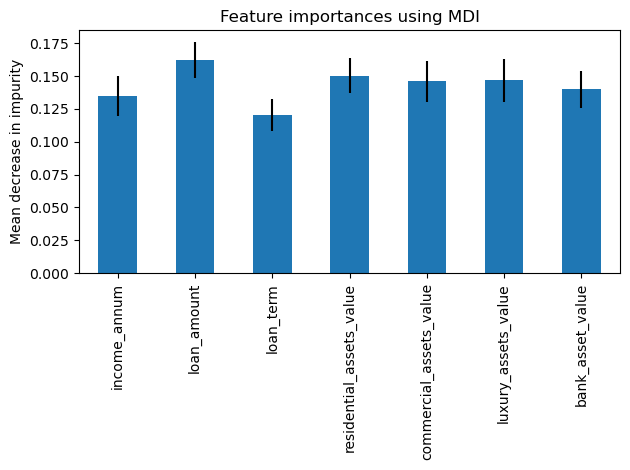

In [46]:
forest_importances = pd.Series(importances, index=brfc_sfs.k_feature_names_)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()